In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


1.14.0


In [2]:
Y = 'TKW'
df = pd.read_csv('data/prepared.csv', sep='\t')

In [3]:
df.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Chr7D-B17-Hap1,TKW,Balcarce,Azul,MsJz,2012,2013,2014,2015,2016
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,28.19,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,26.23,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [4]:
df.drop(columns={'2012','2013','2014','2015','2016'}, inplace=True)

In [5]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)


In [6]:
train_stats = train_dataset.describe()
train_stats.pop(Y)
train_stats = train_stats.transpose()



In [7]:
train_labels = train_dataset.pop(Y)
test_labels = test_dataset.pop(Y)


In [8]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [9]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
      ])

    optimizer = tf.keras.optimizers.RMSprop(0.0001)

    model.compile(loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


In [10]:
model = build_model()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320960    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 325,185
Trainable params: 325,185
Non-trainable params: 0
_________________________________________________________________


In [12]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result


array([[-1.3416089 ],
       [-0.00204819],
       [-0.5539992 ],
       [-0.10875216],
       [ 1.7859027 ],
       [ 0.69871986],
       [ 0.11221504],
       [-1.6251271 ],
       [ 0.333382  ],
       [ 0.8371244 ]], dtype=float32)

In [13]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

        
EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])



...........................................................

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
54,24.661483,3.976685,24.661480,28.021975,4.105245,28.021978,54
55,24.764641,3.999718,24.764643,27.247102,4.030079,27.247103,55
56,24.542745,3.955368,24.542744,26.574785,4.047832,26.574783,56
57,24.406192,3.955731,24.406193,27.205501,4.081542,27.205502,57
58,24.083468,3.907271,24.083467,27.035740,4.019681,27.035740,58


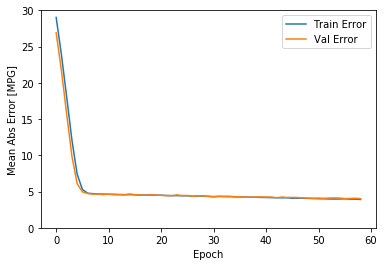

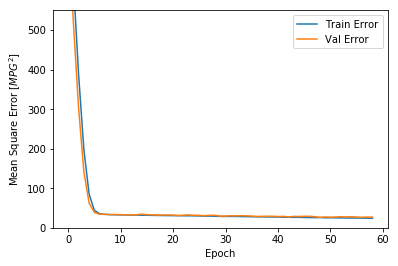

In [15]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,550])
    plt.legend()
    plt.show()


plot_history(history)


In [16]:
def unnorm(x):
    return (x * train_stats['std']) +  train_stats['mean']

In [17]:
test_dataset.head(2)

,Chr1A-B1-Hap1,Chr1A-B1-Hap2,Chr1A-B1-Hap3,Chr1A-B1-Hap4,Chr1A-B1-Hap5,Chr1A-B1-Hap6,Chr1A-B1-Hap7,Chr1A-B2-Hap1,Chr1A-B2-Hap2,Chr1A-B2-Hap3,...,Chr7D-B15-Hap1,Chr7D-B15-Hap2,AX-95152265,AX-94653866,Chr7D-B16-Hap1,Chr7D-B16-Hap2,Chr7D-B17-Hap1,Balcarce,Azul,MsJz
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [18]:

def f_city(x):
    if x['Balcarce'] == 1.0: return 'Balcarce'
    if x['Azul'] == 1.0: return 'Azul'
    if x['MsJz'] == 1.0: return 'MsJz'

test_dataset['city'] = test_dataset.apply(f_city, axis=1)



In [ ]:


def f_year(x):
    if x['2012'] == 1.0: return '2012'
    if x['2013'] == 1.0: return '2013'
    if x['2014'] == 1.0: return '2014'
    if x['2015'] == 1.0: return '2015'
    if x['2016'] == 1.0: return '2016'

test_dataset['year'] = test_dataset.apply(f_year, axis=1)

In [ ]:
test_dataset.head(2)

In [ ]:
test_dataset.year.unique()

In [20]:
test_labels[:10]

11    28.60
23    28.04
24    27.41
25    26.48
28    36.44
32    35.53
33    35.75
36    35.02
41    25.56
43    35.80
Name: TKW, dtype: float64

In [21]:
example_batch = normed_test_data
example_result = model.predict(example_batch)
example_result[:10]


array([[30.366802],
       [31.449028],
       [31.449028],
       [31.449028],
       [31.449028],
       [34.741104],
       [34.741104],
       [31.502262],
       [31.502262],
       [31.502262]], dtype=float32)

In [22]:
res = [x[0] for x in example_result]

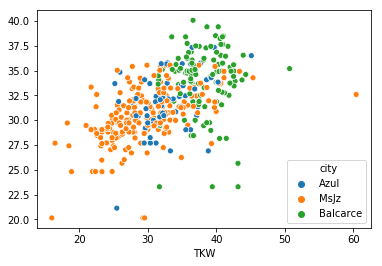

In [23]:
sns.scatterplot(x=test_labels,y=res,hue=test_dataset.city)
plt.show()

In [24]:
import eli5
from eli5.sklearn import PermutationImportance


Using TensorFlow backend.


In [25]:
perm = PermutationImportance(model, random_state=1, scoring="r2").fit(normed_train_data,train_labels)


In [26]:
eli5.show_weights(perm, feature_names = normed_train_data.columns.tolist())


Weight,Feature
0.1437 ± 0.0127,Balcarce
0.1240 ± 0.0089,MsJz
0.0019 ± 0.0013,Azul
0.0015 ± 0.0008,Chr3B-B91-Hap2
0.0015 ± 0.0007,Chr1A-B42-Hap4
0.0015 ± 0.0012,Chr3A-B39-Hap2
0.0013 ± 0.0004,Chr4A-B20-Hap3
0.0013 ± 0.0004,Chr4A-B48-Hap5
0.0013 ± 0.0005,Chr5B-B28-Hap2
0.0012 ± 0.0006,Chr5A-B74-Hap3


In [ ]:
sns.scatterplot(x=test_labels,y=res,hue=test_dataset.year)
plt.show()

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
